# Halloween Viz EDA
In this notebook, I am going to explore the [Halloween Viz dataset](https://www.dataplusscience.com/HalloweenData.html) created by [Jeffrey A. Shaffer](https://twitter.com/HighVizAbility), a resident of Cincinnati on the number of candies given out on Halloween each year. The dataset is further broken down into number of candies given out each half an hour between the trick-or-treat timings (6 to 8 p.m.). Jeffrey is an _"Author, Data Viz Professor, Tableau Zen Master, Data Mining Geek, Recovering Musician"_ (Source: Twitter).

## Creating a Story
This dataset is simple and can can be combined with other external datasets to provide better insight into the trick-or-treat figures. I will be considering [IMDB's horror movies dataset](https://www.kaggle.com/PromptCloudHQ/imdb-horror-movie-dataset) to build on the halloween dataset. I will be counting the number of movies released in a paritcular year and the average IMDB rating of the movie.
> **The relationship between the number of _good_ horror movies released and number of candies distributed in a particular can be explored.**

Later, a simple regression model can be used to make predicitons on what the demand for candies will be like in 2021.

_Note: As 2020 had been the year of the pandemic, there should be a sharp rise in the number of trick-or-treaters in 2021._


# Loading Libraries

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from tqdm import tqdm
import pathlib
import os
import matplotlib.pyplot as plt

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Loading Data

In [4]:
data_dir = "Data"
filename = "IMDB Horror movies.csv"
path = pathlib.Path(os.path.join(data_dir, filename))

if not path.exists():
    raise FileNotFoundError(f"No file named {filename} is present at the location provided. Path: {path}")
else:
    print(f"File {filename} exists.")

File IMDB Horror movies.csv exists.


In [52]:
if path.suffix == ".xlsx":
    horror_df = pd.read_excel(path)
elif path.suffix == ".csv":
    horror_df = pd.read_csv(path, parse_dates=True)

horror_df.head()

,Title,Genres,Release Date,Release Country,Movie Rating,Review Rating,Movie Run Time,Plot,Cast,Language,Filming Locations,Budget
0,Gut (2012),Drama| Horror| Thriller,26-Oct-12,USA,NaN,3.9,91 min,"Directed by Elias. With Jason Vail, Nicholas W...",Jason Vail|Nicholas Wilder|Sarah Schoofs|Kirst...,English,"New York, USA",NaN
1,The Haunting of Mia Moss (2017),Horror,13-Jan-17,USA,NaN,NaN,NaN,"Directed by Jake Zelch. With Nicola Fiore, Bri...",Nicola Fiore|Brinke Stevens|Curtis Carnahan|Ja...,English,NaN,"$30,000"
2,Sleepwalking (2017),Horror,21-Oct-17,Canada,NaN,NaN,NaN,"Directed by David Briggs. With Alysia Topol, A...",Alysia Topol|Anthony Makela|Kelsi Ashley|Patri...,English,"Sudbury, Ontario, Canada",NaN
3,Treasure Chest of Horrors II (2013),Comedy| Horror| Thriller,23-Apr-13,USA,NOT RATED,3.7,82 min,"Directed by M. Kelley, Shawn C. Phillips, Alex...",Veronica Ricci|Nicholas Adam Clark|James Culle...,English,"Baltimore, Maryland, USA",NaN
4,Infidus (2015),Crime| Drama| Horror,10-Apr-15,USA,NaN,5.8,80 min,"Directed by Giulio De Santi. With Bonini Mino,...",Bonini Mino|Massimo Caratelli|Maurizio Zaffino...,Italian,NaN,NaN


# Understanding the Data
Pandas profiling is used to better understand the dataset.

In [12]:
profile = ProfileReport(horror_df)
profile.to_widgets()

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
horror_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              3328 non-null   object 
 1   Genres             3327 non-null   object 
 2   Release Date       3328 non-null   object 
 3   Release Country    3328 non-null   object 
 4   Movie Rating       1451 non-null   object 
 5   Review Rating      3076 non-null   float64
 6   Movie Run Time     2784 non-null   object 
 7   Plot               3327 non-null   object 
 8   Cast               3314 non-null   object 
 9   Language           3257 non-null   object 
 10  Filming Locations  2096 non-null   object 
 11  Budget             1234 non-null   object 
dtypes: float64(1), object(11)
memory usage: 312.1+ KB


# Pre-processing Data
In this section, the data will be converted in to the required format and reduced to something that can easily be combined with halloween viz dataset.

In [54]:
# Converting to datetime object.
(pd.to_datetime(horror_df["Release Date"], format="%d-%b-%y", errors="ignore") == '2017').value_counts()[True]

119

In [55]:
# Number of movies with a release date of `2017`
len(horror_df[horror_df["Release Date"] == '2017'])

119

> As both the above values are the same, it can be concluded that the conversion from `string` to `datetime obj` has successfully taken place.

In [56]:
horror_df["Release Date"] = pd.to_datetime(horror_df["Release Date"], format="%d-%b-%y", errors="ignore")

In [57]:
# Removing columns that are not needed
keep_cols = ["Release Date", "Movie Rating", "Release Country", "Filming Locations"]
horror_df_reduced = horror_df[keep_cols].copy()
horror_df_reduced.head()

,Release Date,Movie Rating,Release Country,Filming Locations
0,26-Oct-12,NaN,USA,"New York, USA"
1,13-Jan-17,NaN,USA,NaN
2,21-Oct-17,NaN,Canada,"Sudbury, Ontario, Canada"
3,23-Apr-13,NOT RATED,USA,"Baltimore, Maryland, USA"
4,10-Apr-15,NaN,USA,NaN


We are only interested in the movies released in the `USA`. Hence, movies released in other countries are dropped.

In [63]:
horror_df2 = horror_df_reduced[horror_df_reduced["Release Country"] == "USA"].copy()
horror_df2.head()

,Release Date,Movie Rating,Release Country,Filming Locations
0,26-Oct-12,NaN,USA,"New York, USA"
1,13-Jan-17,NaN,USA,NaN
3,23-Apr-13,NOT RATED,USA,"Baltimore, Maryland, USA"
4,10-Apr-15,NaN,USA,NaN
6,3-Jun-14,NOT RATED,USA,NaN


In [64]:
# Dropping the Release Country columns
horror_df2.drop(["Release Country"], axis=1, inplace=True)
horror_df2.head()

,Release Date,Movie Rating,Filming Locations
0,26-Oct-12,NaN,"New York, USA"
1,13-Jan-17,NaN,NaN
3,23-Apr-13,NOT RATED,"Baltimore, Maryland, USA"
4,10-Apr-15,NaN,NaN
6,3-Jun-14,NOT RATED,NaN


In [76]:
# Getting the release year for each movie
years = []

for date in tqdm(horror_df2["Release Date"].values):
    if date.find('-') == -1:
        years.append(date)
    else:
        years.append(datetime.datetime.strptime(date, "%d-%b-%y").year)

100%|██████████| 2092/2092 [00:00<00:00, 78663.88it/s]


In [77]:
# Adding Release Year to the DataFrame
horror_df2['Release Year'] = pd.Series(years)
horror_df2.head()

,Release Date,Movie Rating,Filming Locations,Release Year
0,26-Oct-12,NaN,"New York, USA",2012
1,13-Jan-17,NaN,NaN,2017
3,23-Apr-13,NOT RATED,"Baltimore, Maryland, USA",2015
4,10-Apr-15,NaN,NaN,2014
6,3-Jun-14,NOT RATED,NaN,2012


In [79]:
horror_df2["Release Year"].describe()

count     1256
unique      12
top       2017
freq       264
Name: Release Year, dtype: int64

As it can be seen above, now there are only `12` unique values. The most common being `2017`. Now the data can be easily split using the `Release Year`.

In [80]:
horror_df2["Release Year"].value_counts()

2017    264
2016    236
2015    219
2014    186
2013    150
2012    104
2017     52
2016     15
2015     11
2012      7
2014      7
2013      5
Name: Release Year, dtype: int64

# Loading New Dataset
The following dataset is obtained from the [official IMDB Website](https://www.imdb.com/interfaces/). As the halloween dataset is available from `2008` to `2020`, we would like to get data regarding the number of horror movies released for the same time period. Furthermore, the average rating of the horror movies for each year is to be used for the visualization.

In [97]:
imdb_rating_df = pd.read_csv(os.path.join(data_dir, "data.tsv"), sep="\t", index_col=["tconst"])
imdb_rating_df.head()

,averageRating,numVotes
tconst,,
tt0000001,5.7,1688
tt0000002,6.0,208
tt0000003,6.5,1429
tt0000004,6.1,122
tt0000005,6.1,2229


In [84]:
imdb_basic_df = pd.read_csv(os.path.join(data_dir, "data-2.tsv"), sep="\t", index_col=["tconst"], low_memory=False)
imdb_basic_df.head()

/Users/raj/Documents/Canada/Durham/1202-Data_Analysis_Tools_Analytics/Assignments/halloween_assignment/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [107]:
# Dropping columns that are not required
del_cols = ["titleType",
            "primaryTitle"]
imdb_basic_df.drop(del_cols, axis=1, inplace=True)

AttributeError: 'NoneType' object has no attribute 'drop'

In [101]:
# Combining the two datasets
imdb_df = pd.concat([imdb_basic_df, imdb_rating_df], axis=1)

# Dropping all the missing values
imdb_df.dropna(inplace=True)

imdb_df.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1688.0
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0,208.0
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1429.0
tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.1,122.0
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.1,2229.0


In [102]:
# Reduce memory consumption
imdb_basic_df = None

In [103]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7686750 entries, tt0000001 to tt6982250
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   titleType       object 
 1   primaryTitle    object 
 2   originalTitle   object 
 3   isAdult         object 
 4   startYear       object 
 5   endYear         object 
 6   runtimeMinutes  object 
 7   genres          object 
 8   averageRating   float64
 9   numVotes        float64
dtypes: float64(2), object(8)
memory usage: 645.1+ MB


In [130]:
# Filter data by year of release
imdb_df2 = imdb_df[imdb_df["startYear"] != "\\N"].dropna()
imdb_df2.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1688.0
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0,208.0
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1429.0
tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.1,122.0
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.1,2229.0


In [131]:
imdb_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1129125 entries, tt0000001 to tt9916778
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   titleType       1129125 non-null  object 
 1   primaryTitle    1129125 non-null  object 
 2   originalTitle   1129125 non-null  object 
 3   isAdult         1129125 non-null  object 
 4   startYear       1129125 non-null  object 
 5   endYear         1129125 non-null  object 
 6   runtimeMinutes  1129125 non-null  object 
 7   genres          1129125 non-null  object 
 8   averageRating   1129125 non-null  float64
 9   numVotes        1129125 non-null  float64
dtypes: float64(2), object(8)
memory usage: 94.8+ MB


In [138]:
# Filtering out horror movies or series
imdb_horror_df = imdb_df2[imdb_df2["genres"].str.contains("Horror")]
imdb_horror_df.head()

,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,
tt0000075,Escamotage d'une dame au théâtre Robert Houdin,0,1896,\N,1,"Horror,Short",6.3,1633.0
tt0000091,Le manoir du diable,0,1896,\N,3,"Horror,Short",6.7,2959.0
tt0000131,Une nuit terrible,0,1896,\N,1,"Comedy,Horror,Short",5.8,1143.0
tt0000138,L'auberge ensorcelée,0,1897,\N,2,"Comedy,Horror,Short",6.4,917.0
tt0000152,L'hallucination de l'alchimiste,0,1897,\N,2,"Fantasy,Horror,Short",6.1,188.0


In [157]:
# Filtering the data by year
start_year = 2008
end_year = 2021     # not included
imdb_horror_df2 = imdb_horror_df[(imdb_horror_df["startYear"].astype(int) >= start_year) & 
                                 (imdb_horror_df["startYear"].astype(int) < end_year)]
imdb_horror_df2.head()

,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,
tt0112502,Bigfoot,0,2017,\N,\N,"Horror,Thriller",4.5,33.0
tt0164388,Shadow of a Candle,0,2008,\N,\N,"Horror,Short,Thriller",6.9,10.0
tt0200641,Flexing with Monty,0,2010,\N,90,"Comedy,Drama,Horror",3.8,241.0
tt0289146,T.M.A.,0,2009,\N,100,"Horror,Mystery,Thriller",4.6,163.0
tt0319115,Brothel,0,2008,\N,96,"Drama,Horror",4.1,222.0


In [159]:
# Checking the unique year values
imdb_horror_df2["startYear"].unique()

array([2017, 2008, 2010, 2009, 2011, 2012, 2014, 2013, 2016, 2019, 2018,
       2020, 2015])

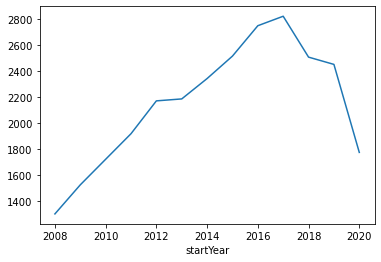

In [171]:
# plotting number of horror movies released over the years
imdb_horror_df2.groupby("startYear").count()["averageRating"].plot();

<AxesSubplot:xlabel='startYear'>

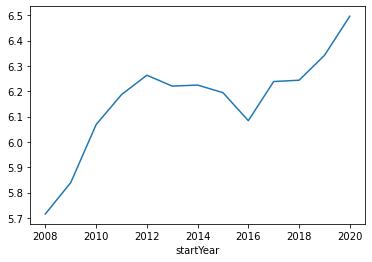

In [207]:
# Plotting average rating of horror movies over the years
imdb_horror_df2.groupby("startYear").mean()["averageRating"].plot();

In [208]:
# Saving the horror movies dataset
new_filename = "IMDB Horror (Processed) Dataset.csv"
imdb_horror_df2.to_csv(os.path.join(data_dir, new_filename))
print(f"File {new_filename} saved.")

File IMDB Horror (Processed) Dataset.csv saved.


# Viewing the Halloween Dataset

In [210]:
# Loading dataset
halloween_df = pd.read_excel(os.path.join(data_dir, "HalloweenTableau2020.xlsx"), parse_dates=True)
halloween_df.head()

,Date,Date and Time,Count,Day of Week,Time
0,2008-10-31,2008-10-31 18:00:00,0,Friday,6:00pm
1,2008-10-31,2008-10-31 18:30:00,75,Friday,6:30pm
2,2008-10-31,2008-10-31 19:00:00,117,Friday,7:00pm
3,2008-10-31,2008-10-31 19:30:00,147,Friday,7:30pm
4,2008-10-31,2008-10-31 20:00:00,144,Friday,8:00pm


In [211]:
# Creating the `Year` variable
halloween_df["Year"] = halloween_df["Date and Time"].dt.year
halloween_df.head()

,Date,Date and Time,Count,Day of Week,Time,Year
0,2008-10-31,2008-10-31 18:00:00,0,Friday,6:00pm,2008
1,2008-10-31,2008-10-31 18:30:00,75,Friday,6:30pm,2008
2,2008-10-31,2008-10-31 19:00:00,117,Friday,7:00pm,2008
3,2008-10-31,2008-10-31 19:30:00,147,Friday,7:30pm,2008
4,2008-10-31,2008-10-31 20:00:00,144,Friday,8:00pm,2008


In [212]:
# Updating the index to view data in a comprehensive manner.
halloween_df.set_index(["Year", "Time"], inplace=True)
halloween_df.head()

Date       Date and Time  Count Day of Week
Year Time                                                    
2008 6:00pm 2008-10-31 2008-10-31 18:00:00      0      Friday
     6:30pm 2008-10-31 2008-10-31 18:30:00     75      Friday
     7:00pm 2008-10-31 2008-10-31 19:00:00    117      Friday
     7:30pm 2008-10-31 2008-10-31 19:30:00    147      Friday
     8:00pm 2008-10-31 2008-10-31 20:00:00    144      Friday

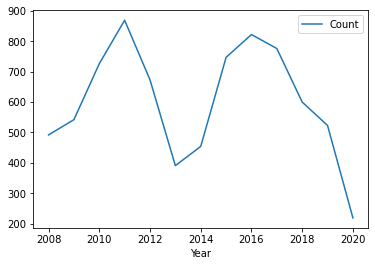

In [203]:
# Plotting number of candies treated by year
halloween_df.groupby("Year").sum().plot();